# **Evaluation Metrics**

# RAGAS EVALUATION

In [15]:
!pip install numpy pandas matplotlib seaborn sentence-transformers scikit-learn stanza ipython


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict
from IPython.display import display

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

In [32]:

# Initialize logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Use Urdu-specific NER model
tokenizer = AutoTokenizer.from_pretrained("mirfan899/urdu-bert-ner")
model = AutoModelForTokenClassification.from_pretrained("mirfan899/urdu-bert-ner")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


Device set to use mps:0


Error while downloading from https://cdn-lfs.hf.co/repos/b9/f6/b9f61c5011faea157dbddf9e74d7b35a586e9864799385bb396c1c1ba0ddaa50/3cf028f24559b0f7cdfc42188206d0924cfd59180c39b3f5ada3ebe5694c1ca0?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1747682241&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NzY4MjI0MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9iOS9mNi9iOWY2MWM1MDExZmFlYTE1N2RiZGRmOWU3NGQ3YjM1YTU4NmU5ODY0Nzk5Mzg1YmIzOTZjMWMxYmEwZGRhYTUwLzNjZjAyOGYyNDU1OWIwZjdjZGZjNDIxODgyMDZkMDkyNGNmZDU5MTgwYzM5YjNmNWFkYTNlYmU1Njk0YzFjYTA%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=ZbcF0utmR0hPuZHbeCAcb%7EUIjs7JuIZlmZezbOVZ8tY%7EQOAlb388dAt93x8oCc3Ys6DvheXxjWRXV0x1QXizMXWaexW14yInQwNQRp6ReQgQ7ngHD%7EF7OUKyq%7EYMApe12qKRy2cdgvLzoYMgCmhx4k9sZTUF8Wn4y4C1fdk%7EXeWLjCtm8vjkhUQ-YDk10nD5ciuXxGgvM4a-SSVZCm-pv4ri0fDgEjvLiss-AKr1lfn2Bl9HzyL6JIlKahROP-zxy

In [39]:
class RAGEvaluator:
    def __init__(self, sentence_transformer: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        logger.info("Initializing RAG Evaluator...")
        self.model = SentenceTransformer(sentence_transformer)

    def compute_cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        return float(cosine_similarity([vec1], [vec2])[0][0])

    def evaluate_faithfulness(self, generated_answer: str, context: str) -> float:
        context_embedding = self.model.encode([context])[0]
        answer_embedding = self.model.encode([generated_answer])[0]
        return self.compute_cosine_similarity(context_embedding, answer_embedding)

    def evaluate_answer_relevancy(self, answer: str, query: str) -> float:
        query_embedding = self.model.encode([query])[0]
        answer_embedding = self.model.encode([answer])[0]
        return self.compute_cosine_similarity(query_embedding, answer_embedding)

    def extract_entities(self, text: str) -> set:
        try:
            ner_results = ner_pipeline(text)
            entities = {ent['word'].strip() for ent in ner_results if ent['score'] > 0.6}
            return entities
        except Exception as e:
            logger.error(f"NER extraction error: {str(e)}")
            return set()

    def evaluate_context_metrics(self, query: str, context: str) -> Dict[str, float]:
        query_entities = self.extract_entities(query)
        context_entities = self.extract_entities(context)

        if not query_entities:
            return {"recall": 0.0, "precision": 0.0}

        intersection = query_entities.intersection(context_entities)
        recall = len(intersection) / len(query_entities)
        precision = len(intersection) / len(context_entities) if context_entities else 0.0

        return {"recall": recall, "precision": precision}

    def evaluate_entity_recall(self, retrieved_context: str, ground_truth_context: str) -> float:
        retrieved_entities = self.extract_entities(retrieved_context)
        truth_entities = self.extract_entities(ground_truth_context)
        return len(retrieved_entities.intersection(truth_entities)) / len(truth_entities) if truth_entities else 0.0

    def evaluate_approach(self, query: str, retrieved_context: str, generated_answer: str, ground_truth_context: str) -> Dict[str, float]:
        try:
            context_metrics = self.evaluate_context_metrics(query, retrieved_context)
            return {
                "faithfulness": self.evaluate_faithfulness(generated_answer, retrieved_context),
                "answer_relevancy": self.evaluate_answer_relevancy(generated_answer, query),
                "context_recall": context_metrics["recall"],
                "context_precision": context_metrics["precision"],
                "entity_recall": self.evaluate_entity_recall(retrieved_context, ground_truth_context)
            }
        except Exception as e:
            logger.error(f"Error evaluating approach: {str(e)}")
            return dict.fromkeys(["faithfulness", "answer_relevancy", "context_recall", "context_precision", "entity_recall"], 0.0)


In [40]:

def plot_metric_comparison(results_df: pd.DataFrame, metric_name: str):
    plt.figure(figsize=(10, 6))
    data = pd.DataFrame({
        'Traditional RAG': results_df[f'traditional_{metric_name}'],
        'Modified RAG': results_df[f'modified_{metric_name}']
    })
    sns.boxplot(data=data)
    plt.title(f'{metric_name.replace("_", " ").title()} Comparison')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()

def plot_all_metrics(results_df: pd.DataFrame):
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    fig.suptitle('RAG Evaluation Metrics Comparison', y=1.02, fontsize=16)

    for ax, metric in zip(axes, metrics):
        data = pd.DataFrame({
            'Traditional RAG': results_df[f'traditional_{metric}'],
            'Modified RAG': results_df[f'modified_{metric}']
        })
        sns.boxplot(data=data, ax=ax)
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel('Score')

    plt.tight_layout()
    plt.show()

In [41]:
def evaluate_rag_approaches(input_csv: str) -> pd.DataFrame:
    try:
        logger.info(f"Loading data from {input_csv}")
        df = pd.read_csv(input_csv)

        required_columns = [
            'question', 'context',
            'traditional_rag_retrieved_context', 'traditional_rag_refined_answer',
            'modified_rag_retrieved_context', 'modified_rag_refined_answer'
        ]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        evaluator = RAGEvaluator()
        results = []

        for idx, row in df.iterrows():
            logger.info(f"Evaluating query {idx + 1}/{len(df)}: {row['question'][:50]}...")
            traditional_metrics = evaluator.evaluate_approach(
                row['question'],
                row['traditional_rag_retrieved_context'],
                row['traditional_rag_refined_answer'],
                row['context']
            )
            modified_metrics = evaluator.evaluate_approach(
                row['question'],
                row['modified_rag_retrieved_context'],
                row['modified_rag_refined_answer'],
                row['context']
            )
            result = {
                'query': row['question'],
                'ground_truth_context': row['context'],
                **{f'traditional_{k}': v for k, v in traditional_metrics.items()},
                **{f'modified_{k}': v for k, v in modified_metrics.items()}
            }
            results.append(result)

        results_df = pd.DataFrame(results)

        metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']
        print("\nAverage Metrics:")
        print("-" * 50)
        summary_data = []

        for metric in metrics:
            trad_avg = results_df[f'traditional_{metric}'].mean()
            mod_avg = results_df[f'modified_{metric}'].mean()
            improvement = ((mod_avg - trad_avg) / trad_avg * 100) if trad_avg else float('nan')
            summary_data.append({
                'Metric': metric.replace('_', ' ').title(),
                'Traditional RAG': f"{trad_avg:.3f}",
                'Modified RAG': f"{mod_avg:.3f}",
                'Improvement': f"{improvement:+.1f}%"
            })

        summary_df = pd.DataFrame(summary_data)
        display(summary_df)

        return results_df

    except Exception as e:
        logger.error(f"Error in evaluation process: {str(e)}")
        raise


INFO:__main__:Loading data from Final_Answers_Generated_OpenAI_context.csv
INFO:__main__:Initializing RAG Evaluator...
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
INFO:__main__:Evaluating query 1/899: 3 اپریل کو اولمپک مشعل کس شہر میں تھی؟...
Batches: 100%|██████████| 1/1 [00:00<00:00, 85.57it/s]
INFO:__main__:Evaluating query 2/899: چینی حکومت نے بائیکاٹ کی صورتحال کو کم کرنے کے لئے...
Batches: 100%|██████████| 1/1 [00:00<00:00, 86.77it/s]
INFO:__main__:Evaluating query 3/899: 2008 کے اولمپکس کے لئے پہلے مشعل بردار کا نام کیا ...
Batches: 100%|██████████| 1/1 [00:00<00:00, 77.78it/s]
INFO:__main__:Evaluating query 4/899: کون سی حکومت مشعل کے راستے کی وضاحت کرنے کے لئے اس...
Batches: 100%|██████████| 1/1 [00:00<00:00, 85.67it/s]
INFO:__main__:Evaluating query 5/899: قازقستان میں روٹ کے لئے کلومیٹر میں فاصلہ کیا ت


Average Metrics:
--------------------------------------------------


,Metric,Traditional RAG,Modified RAG,Improvement
0,Faithfulness,0.549,0.485,-11.7%
1,Answer Relevancy,0.661,0.589,-10.8%
2,Context Recall,0.014,0.137,+845.5%
3,Context Precision,0.002,0.032,+1341.7%
4,Entity Recall,0.070,0.102,+46.2%


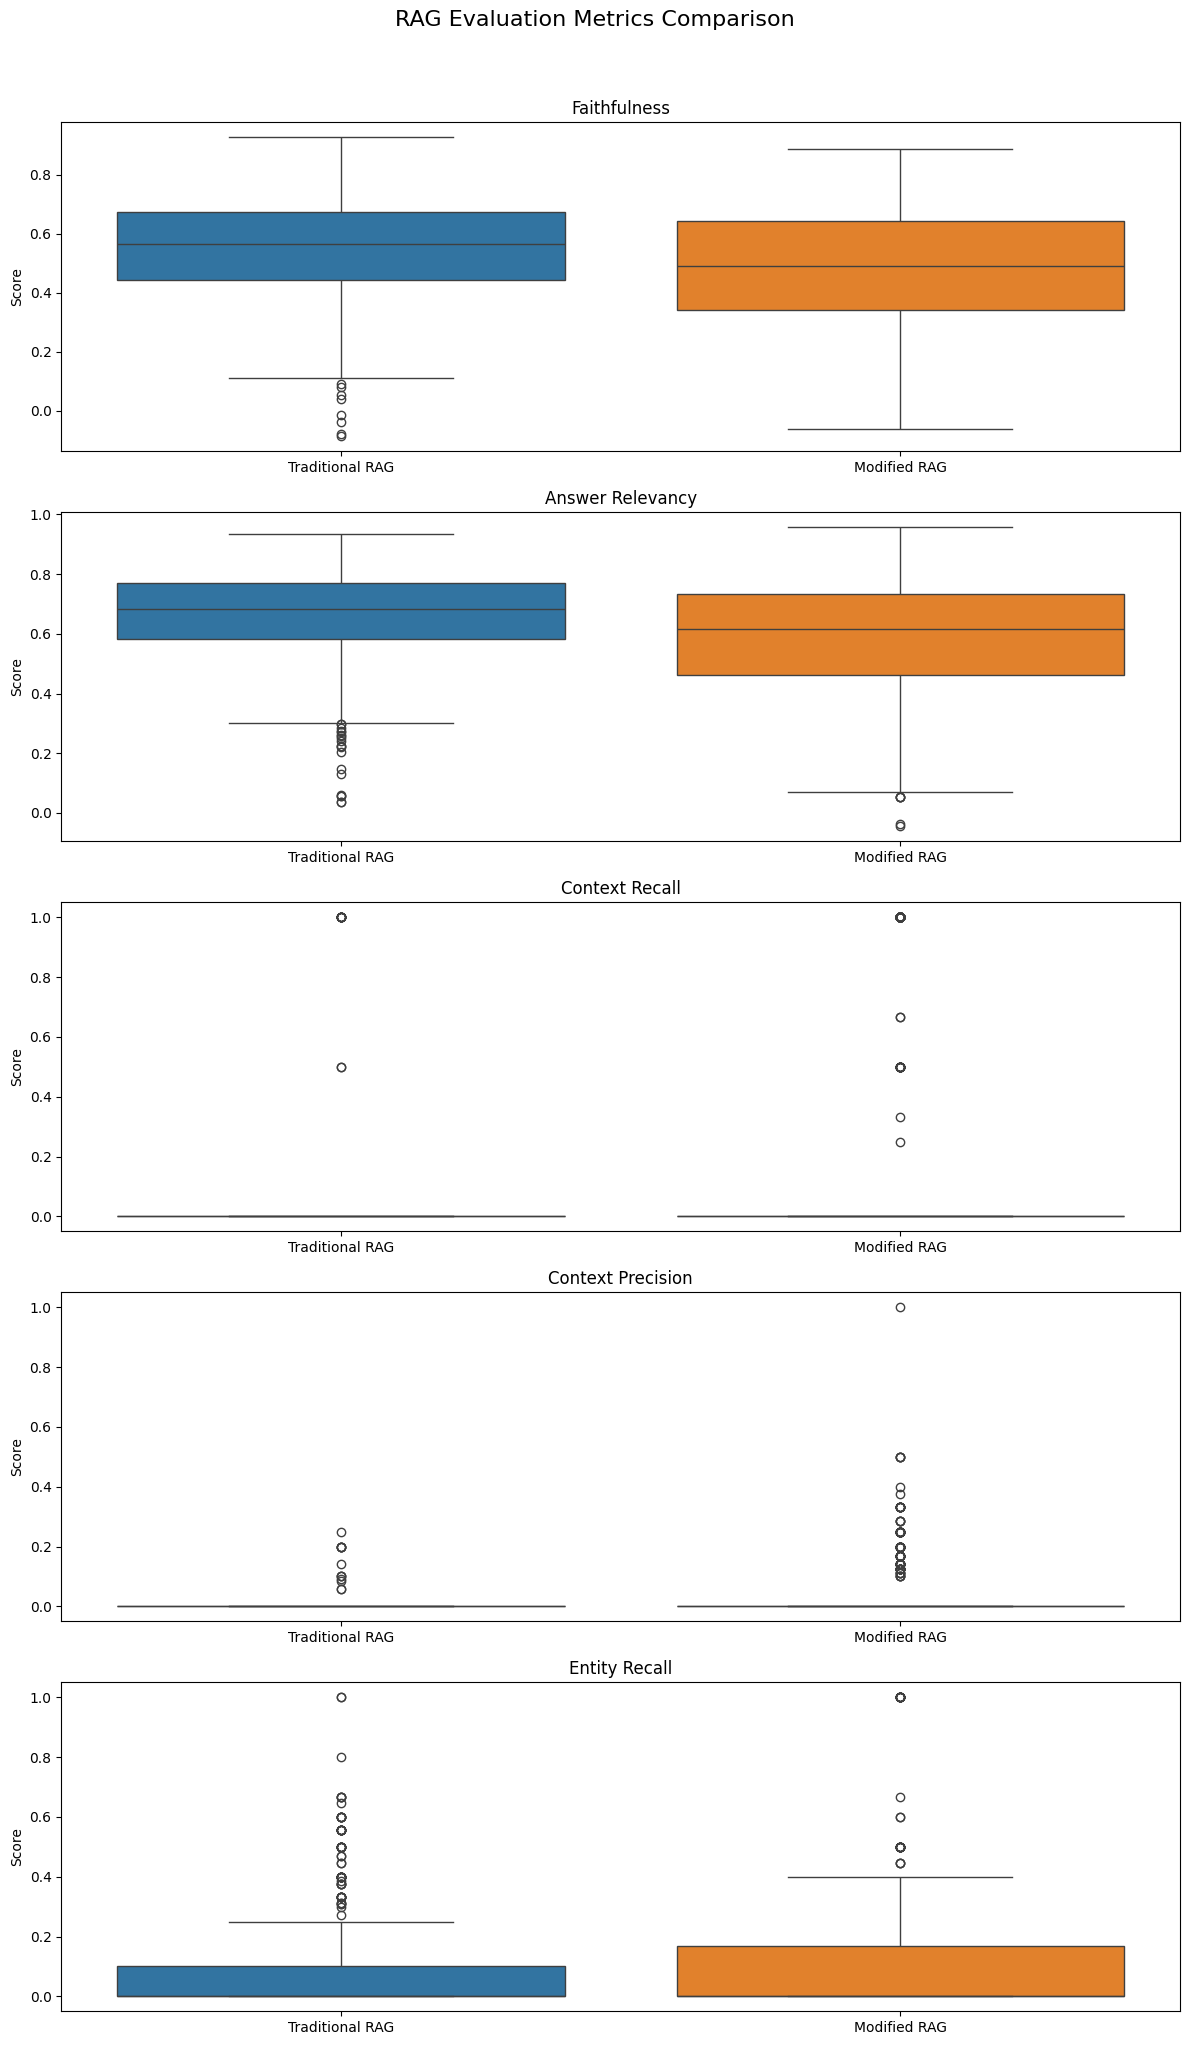

In [42]:
# Run evaluation example
input_csv = 'Final_Answers_Generated_OpenAI_context.csv'  # Adjust path
results_df = evaluate_rag_approaches(input_csv)
plot_all_metrics(results_df)

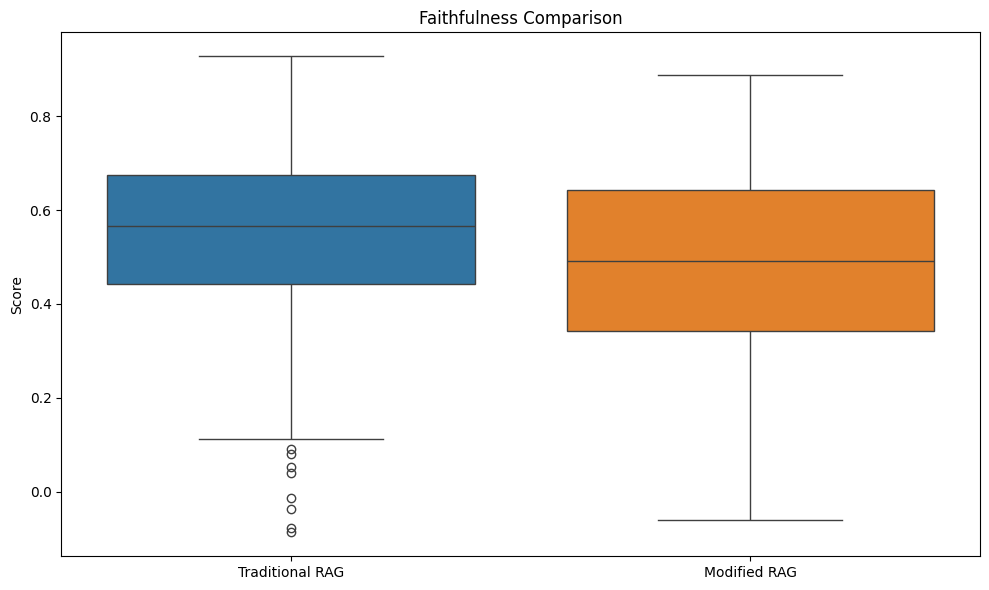

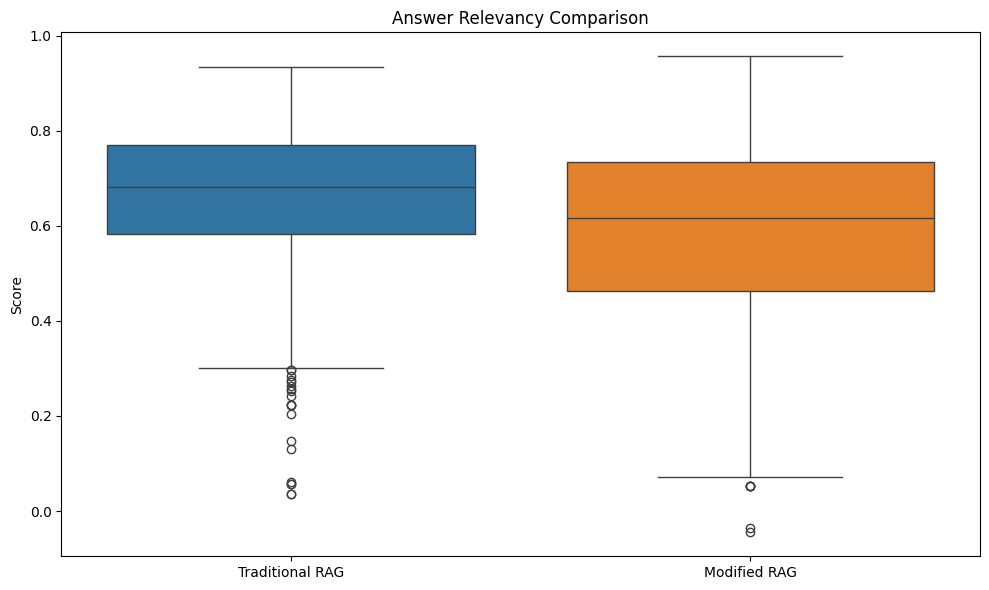

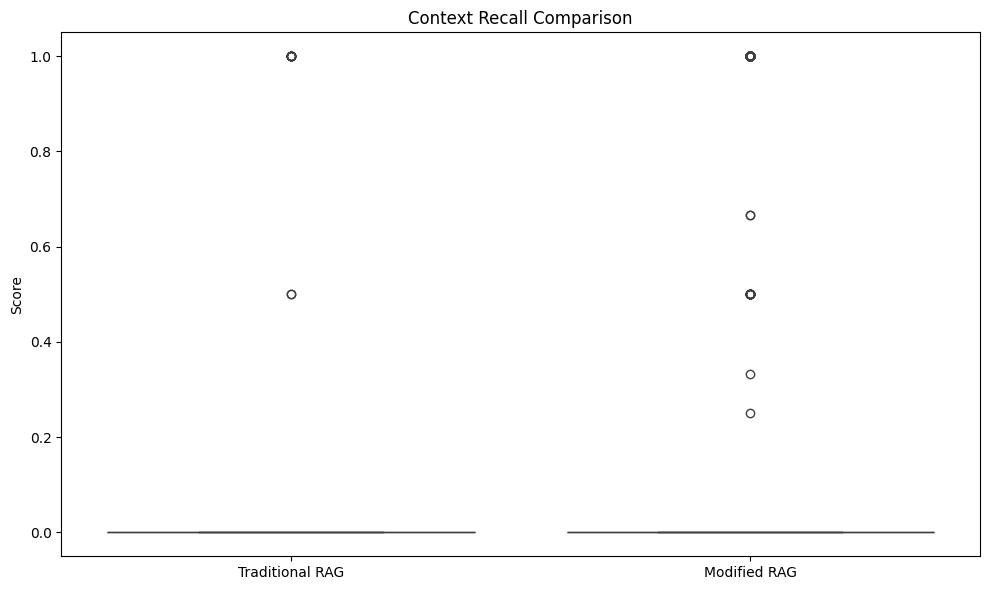

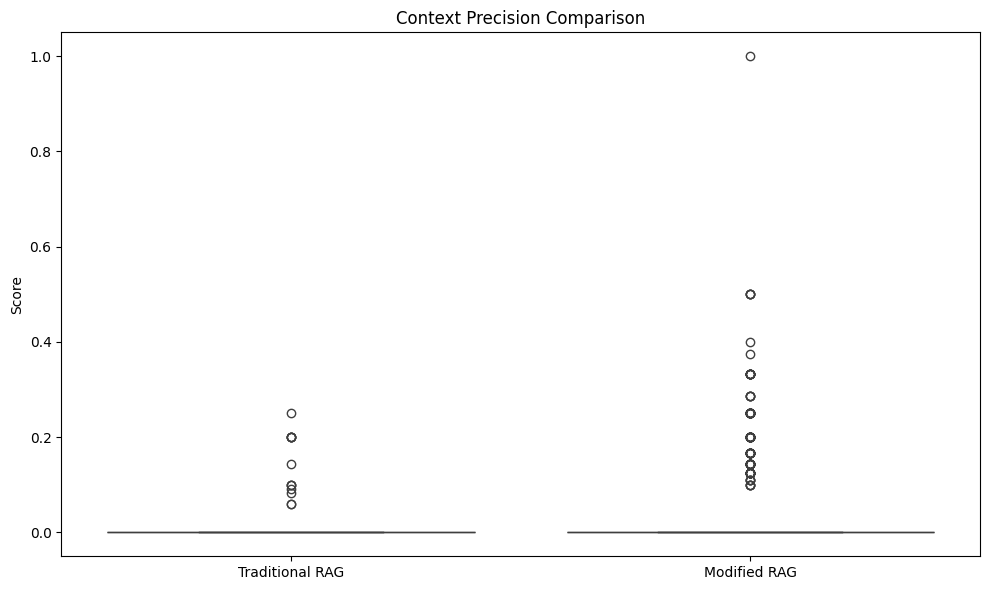

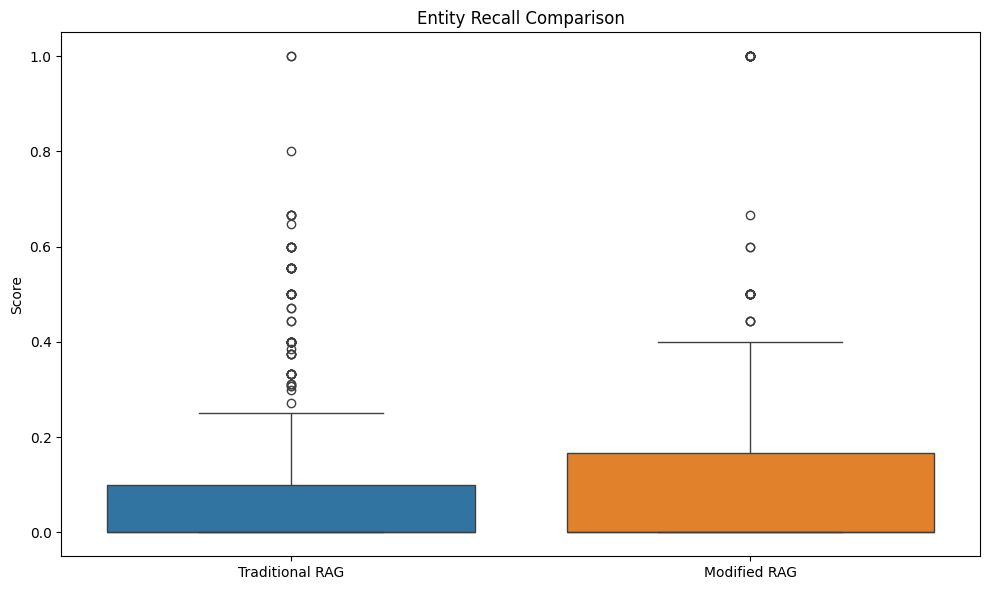

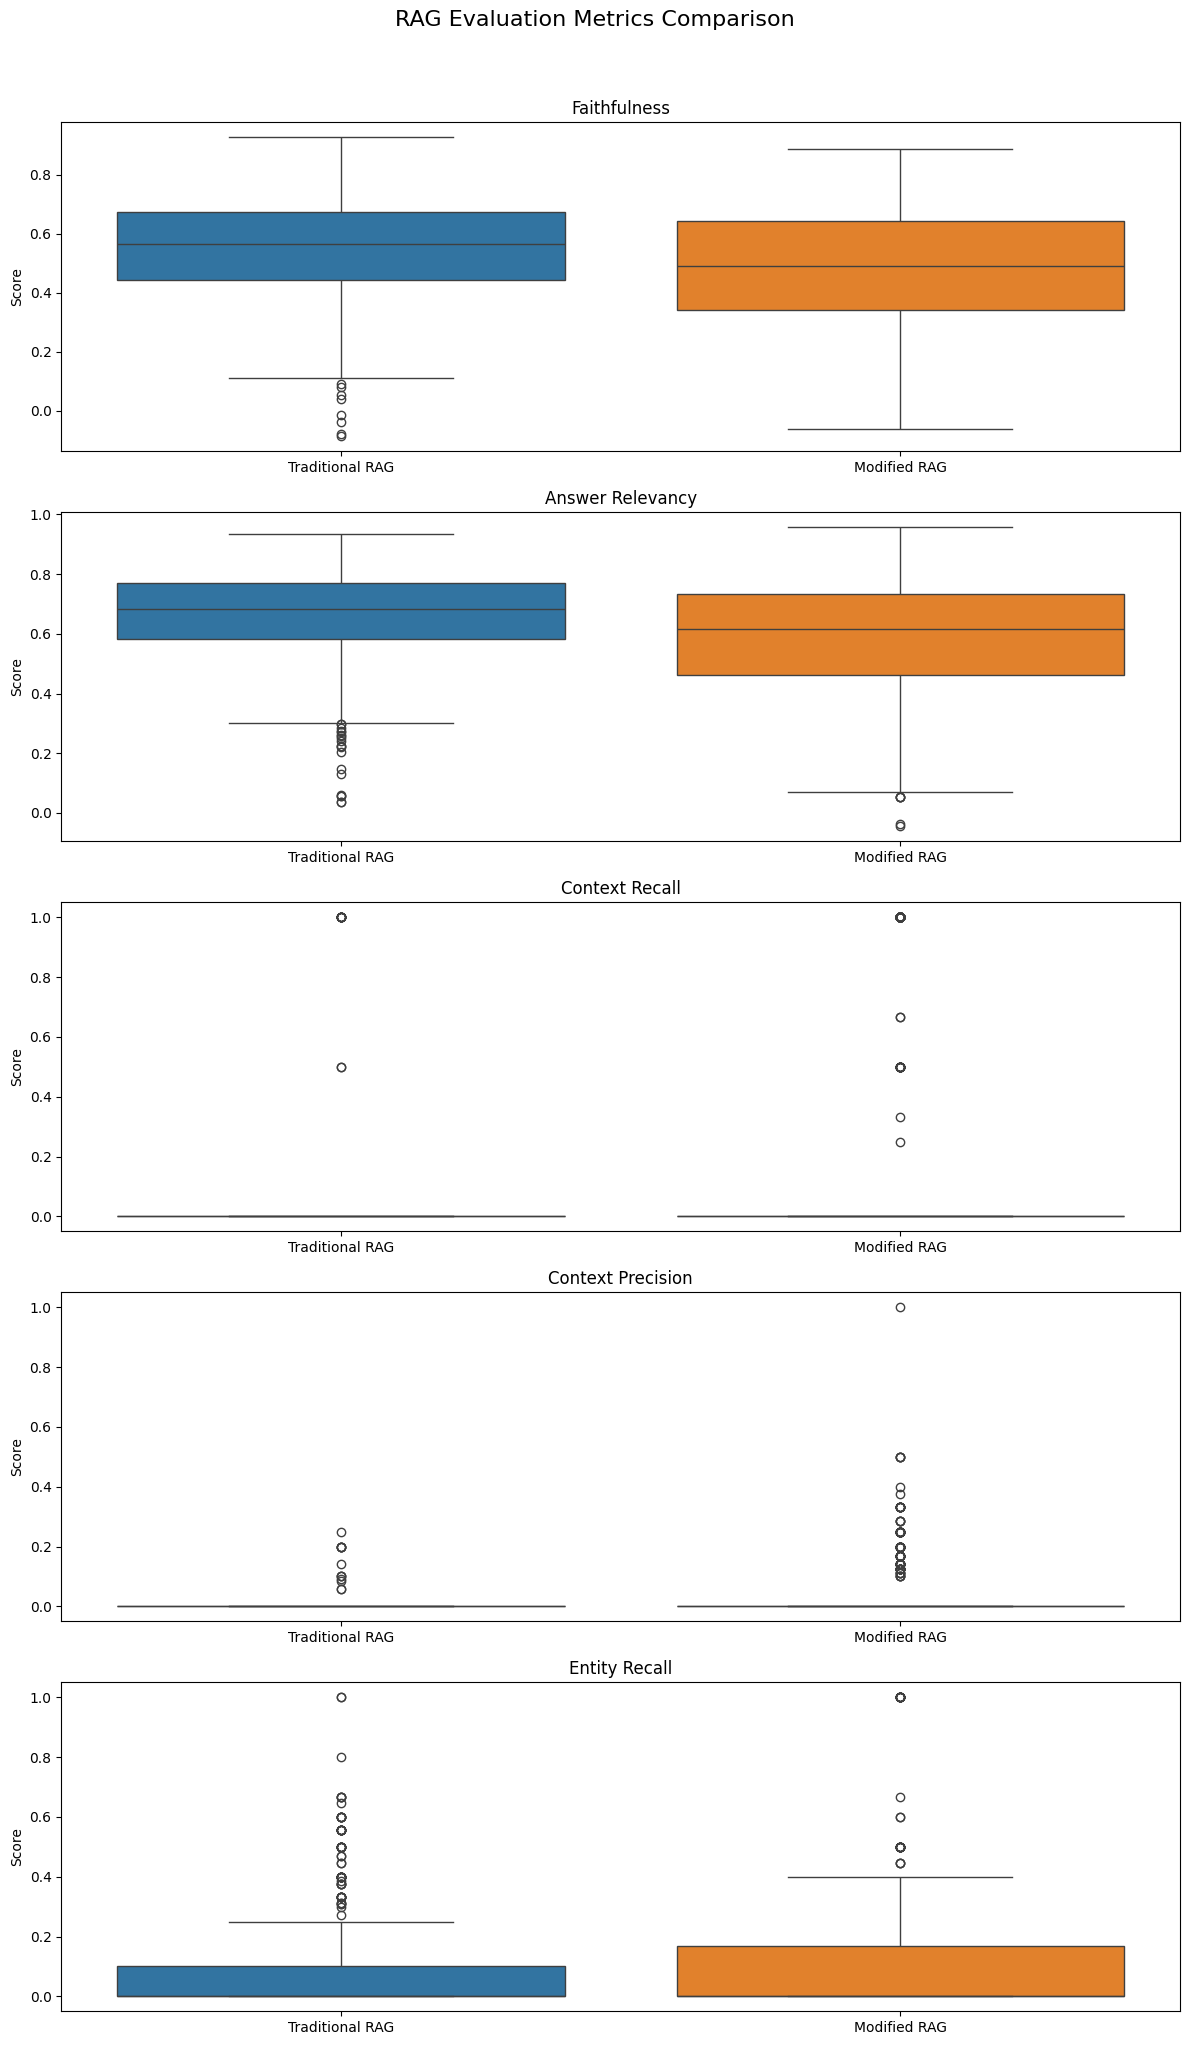

In [43]:
# Cell 6: Generate visualizations
# Plot individual metrics
for metric in ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']:
    plot_metric_comparison(results_df, metric)

# Plot all metrics together
plot_all_metrics(results_df)

In [44]:
# Cell 7: Save results (optional)
results_df.to_csv('Ragas_Evaluation_Result_OpenAI_urdubertNER.csv', index=False)